In [1]:
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
# class names :
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [3]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch6/'
# Trainingsdatensatz:
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [4]:
# Validation data:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [5]:
# find all birds and planes:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [6]:
# baseline convolutional network architecture: 
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [7]:
# baseline convolutional network architecture: 

# 5 x 5 Kernel:
class Net5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=5, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [8]:
# define model:
model = Net()
model5 = Net5()

# Anzahl an Parameter des Models auasgeben:
numel_list = [p.numel() for p in model.parameters()]
print(sum(numel_list), numel_list)

# Gesamtanzahl Parameter: 18090

numel_list5 = [p.numel() for p in model5.parameters()]
print(sum(numel_list5), numel_list5)

18090 [432, 16, 1152, 8, 16384, 32, 64, 2]
20906 [1200, 16, 3200, 8, 16384, 32, 64, 2]


In [9]:
import datetime  
# Trainingsloop für Validierungs- und Trainingsdaten:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    trainingsloss = np.zeros(n_epochs)
    validierungsloss = np.zeros(n_epochs)
    for epoch in range(1, n_epochs + 1): 
        loss_train = 0.0
        for imgs, labels in train_loader: 
            outputs = model(imgs)  
            losses_train = loss_fn(outputs, labels) 
            optimizer.zero_grad()  
            losses_train.backward()  
            optimizer.step()  
            loss_train += losses_train.item()  
    
        loss_val = 0.0 
        for imgs, labels in val_loader: 
            outputs = model(imgs)  
            losses_val = loss_fn(outputs, labels) 
            optimizer.zero_grad()  
            # losses_val.backward()  
            optimizer.step()  
            loss_val += losses_val.item()  

        if epoch == 1 or epoch % 10 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train / len(train_loader):.4f},"
                  f" Validation loss {loss_val / len(val_loader):.4f}")
        
        validierungsloss[epoch-1] = losses_val.detach().numpy() # Valideriungsverlust
        trainingsloss[epoch-1] = losses_train.detach().numpy() # Trainingsverlust
        
    return trainingsloss, validierungsloss

In [10]:
# Training
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)  
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                           shuffle=True)


model = Net()  
optimizer = optim.SGD(model.parameters(), lr=1e-2)  
loss_fn = nn.CrossEntropyLoss()  

trainingsloss, validierungsloss = training_loop(  
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader
)

Epoch 1, Training loss 0.5606, Validation loss 0.4813
Epoch 10, Training loss 0.3329, Validation loss 0.3391
Epoch 20, Training loss 0.2966, Validation loss 0.3108
Epoch 30, Training loss 0.2697, Validation loss 0.2943
Epoch 40, Training loss 0.2457, Validation loss 0.2798
Epoch 50, Training loss 0.2289, Validation loss 0.2753
Epoch 60, Training loss 0.2115, Validation loss 0.2675
Epoch 70, Training loss 0.1956, Validation loss 0.2616
Epoch 80, Training loss 0.1815, Validation loss 0.2531
Epoch 90, Training loss 0.1656, Validation loss 0.2613
Epoch 100, Training loss 0.1539, Validation loss 0.2702


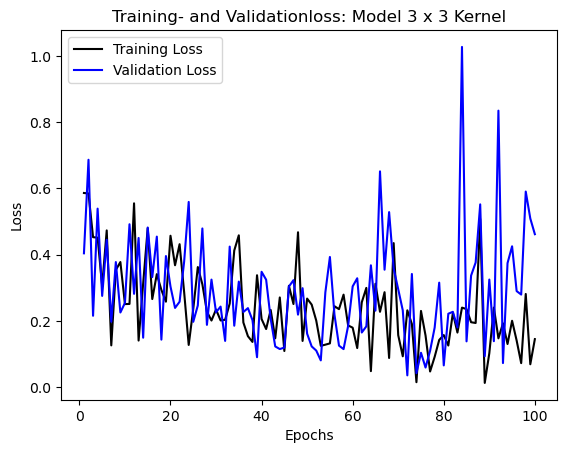

In [11]:
##############################################################################
# Trainings- und Validierungsloss

epochs_train = range(1, len(trainingsloss) + 1) 
epochs_val = range(1, len(validierungsloss) + 1)
fig = plt.figure(dpi=100)
plt.plot(epochs_train, trainingsloss, 'k', label='Training Loss')
plt.plot(epochs_val, validierungsloss, 'b', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training- and Validationloss: Model 3 x 3 Kernel')
plt.legend(loc="best")
plt.show()

In [12]:
import datetime  
# Trainingsloop für Validierungs- und Trainingsdaten: 5 x 5 Kernel
def training_loop5(n_epochs, optimizer5, model5, loss_fn5, train_loader5, val_loader5):
    trainingsloss5 = np.zeros(n_epochs)
    validierungsloss5 = np.zeros(n_epochs)
    for epoch in range(1, n_epochs + 1): 
        loss_train5 = 0.0
        for imgs, labels5 in train_loader5: 
            outputs5 = model(imgs)  
            losses_train5 = loss_fn(outputs5, labels5) 
            optimizer5.zero_grad()  
            losses_train5.backward()  
            optimizer5.step()  
            loss_train5 += losses_train5.item()  
    
        loss_val5 = 0.0 
        for imgs, labels5 in val_loader5: 
            outputs5 = model(imgs)  
            losses_val5 = loss_fn(outputs5, labels5) 
            optimizer5.zero_grad()  
            losses_val5.backward()  
            optimizer5.step()  
            loss_val5 += losses_val5.item()  

        if epoch == 1 or epoch % 10 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train5 / len(train_loader5):.4f},"
                  f" Validation loss {loss_val5 / len(val_loader5):.4f}")
        
        validierungsloss5[epoch-1] = losses_val5.detach().numpy() # Valideriungsverlust
        trainingsloss5[epoch-1] = losses_train5.detach().numpy() # Trainingsverlust
        
    return trainingsloss5, validierungsloss5

In [13]:
# Training (5 x 5 Kernel)

train_loader5 = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)  
val_loader5 = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=True)
 
model5 = Net5()
optimizer5 = optim.SGD(model5.parameters(), lr=1e-2)  
loss_fn5 = nn.CrossEntropyLoss()  

trainingsloss5, validierungsloss5 = training_loop5(  
    n_epochs=100,
    optimizer5=optimizer5,
    model5=model5,
    loss_fn5=loss_fn5,
    train_loader5=train_loader5,
    val_loader5=val_loader5
)

Epoch 1, Training loss 0.1616, Validation loss 0.2619
Epoch 10, Training loss 0.1602, Validation loss 0.2679
Epoch 20, Training loss 0.1607, Validation loss 0.2741
Epoch 30, Training loss 0.1617, Validation loss 0.2634
Epoch 40, Training loss 0.1605, Validation loss 0.2653
Epoch 50, Training loss 0.1603, Validation loss 0.2730
Epoch 60, Training loss 0.1603, Validation loss 0.2702
Epoch 70, Training loss 0.1607, Validation loss 0.2601
Epoch 80, Training loss 0.1607, Validation loss 0.2660
Epoch 90, Training loss 0.1612, Validation loss 0.2626
Epoch 100, Training loss 0.1607, Validation loss 0.2629


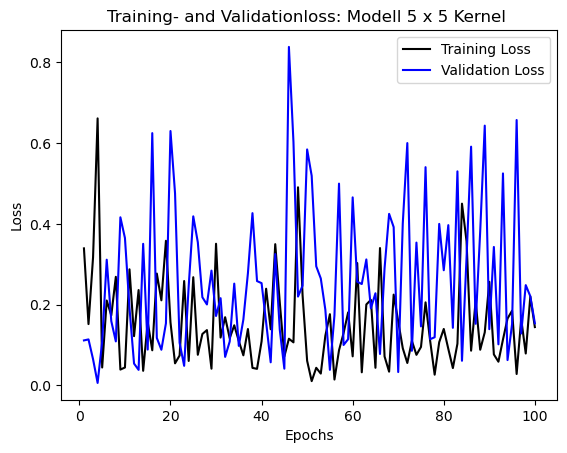

In [14]:
##############################################################################
# Trainings- und Validierungsloss: Kernel 5 x 5

epochs_train = range(1, len(trainingsloss5) + 1) 
epochs_val = range(1, len(validierungsloss5) + 1)
fig = plt.figure(dpi=100)
plt.plot(epochs_train, trainingsloss5, 'k', label='Training Loss')
plt.plot(epochs_val, validierungsloss5, 'b', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training- and Validationloss: Modell 5 x 5 Kernel ')
plt.legend(loc="best")
plt.show()

Die Anzahl der freien Parameter ist beim 5x5 Model teilweise höher, aber der Trainings- und Validierungsloss ist auch minimal größer und stagniert, was für mehr Overfitting spricht.

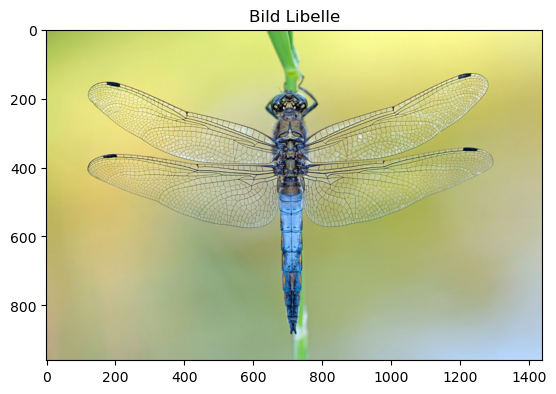

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


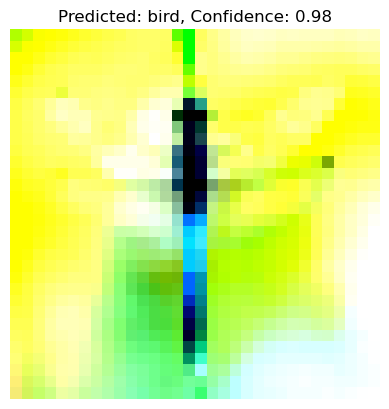

In [28]:
from torchvision import datasets, transforms
import torchvision
from PIL import Image

image = Image.open("Libelle.jpg")
plt.imshow(image)
plt.title('Bild Libelle')
plt.show()

# Bild transformieren
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize Image 
    transforms.ToTensor(),  # Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisierung der Farbkanäle
])

image = transform(image) # Transformation des Bildes, weil Eingabeformat unpassend
outputs = model(image.unsqueeze(0))  # Bild ins Modell geben

probabilities = F.softmax(outputs, dim=1)
confidences, predicted_labels = torch.max(probabilities, dim=1)

m_label = class_names[predicted_labels.item()]  # Klasse
m_confidence = confidences.item()    # Wahrscheinlichkeit
image_predicted = image.squeeze().numpy()  # korrektes Format
image_predicted = image_predicted.transpose((1, 2, 0))
plt.imshow(image_predicted) #Plotten des Bildes
plt.title(f"Predicted: {m_label}, Confidence: {m_confidence:.2f}")
plt.axis('off')
plt.show()

   